# Planar helical antenna array

Helical antennas enable easier polarization matching, and thus a stronger received signal, than a combination of linearly polarized antennas which typically require complicated and lossy polarization switching circuits. 

Although helical antennas are typically curved 3D structures, planar designs using vias have been proposed in literature. This notebook simulates such a quasi-planar design. The limited angular coverage of a single antenna is counteracted by introducing a phased array of 8 elements. 

The array demonstrated in this notebook is designed to operate near the 28 GHz 5G high band, based on the design proposed by Syrytsin et al. in [1]. 

<center><img src="./img/planar_helical_antenna_array_render.png" width=640 /></center>

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tidy3d as td
import tidy3d.rf as rf
from tidy3d import web
from tidy3d.plugins.dispersion import FastDispersionFitter

td.config.logging_level = "ERROR"

## Building the Simulation

### Key Parameters

Key geometry dimensions are defined below. Missing measurements are estimated visually based on available information in [1]. 

<center><img src="./img/planar_helical_antenna_array_schematic.png" width=640 /></center>

In [2]:
mm = 1000  # Conversion factor to micron (default unit)

# Feed line
LF, WF = (1.486 * mm, 0.85 * mm)  # Length and width of feed line
feed_offset = 5 * mm  # Length of feed line overhang

# Helical antenna design
alpha = 15 / 180 * np.pi  # Helix pitch angle
ratio = 0.96  # Size ratio per turn
LH0, WH0 = (3.9 * mm, 0.97 * mm)  # Initial size of trace
LHend = 1.65 * mm  # Final size of 1/8 turn trace
VR = 0.1 * mm  # Via radius

# Phased array parameters
spacing = 5.17 * mm  # Spacing between elements
N_ant = 8  # Number of elements in array

# Substrate/layer dimensions
T = 0.035 * mm  # Trace thickness
H = 1 * mm  # Substrate thickness
Lgnd, Wgnd = (60 * mm, 120 * mm)  # Size of ground plane
Lsub, Wsub = (60 * mm, 129 * mm)  # Size of substrate

The design frequency in [1] is the 28 GHz band of the 5G spectrum. Our approximate design has a central frequency of 29.5 GHz.

In [3]:
# Frequencies and bandwidth
(f_min, f_max) = (20e9, 36e9)
f_target = 29.5e9  # target operating frequency
freqs = np.unique(np.append(np.linspace(f_min, f_max, 201), f_target))

### Medium and Structures

The substrate is Rogers RT5880 and the trace material is copper. Both materials are assumed to have constant loss over the frequency range. 

In [4]:
med_lossy_sub = FastDispersionFitter.constant_loss_tangent_model(2.2, 0.0009, (f_min, f_max))
med_metal = rf.LossyMetalMedium(conductivity=58, frequency_range=(f_min, f_max))

Output()

We commence to build the geometry below. Because of the repetitive nature of the design, we make use of user-defined functions to create the geometry. First, we define a function to create the planar traces of the helical structure. 

In [5]:
def create_trace(size, angle, start_pt, rounded_ends=True):
    """Create trace geometry of given size and angle at start_pt."""
    lt, wt = size
    x0, y0, z0 = start_pt
    x1, y1 = (x0 + lt * np.cos(angle), y0 + lt * np.sin(angle))
    verts = [
        (x0 + wt / 2 * np.sin(angle), y0 - wt / 2 * np.cos(angle)),
        (x0 - wt / 2 * np.sin(angle), y0 + wt / 2 * np.cos(angle)),
        (x1 - wt / 2 * np.sin(angle), y1 + wt / 2 * np.cos(angle)),
        (x1 + wt / 2 * np.sin(angle), y1 - wt / 2 * np.cos(angle)),
    ]
    geom1 = td.PolySlab(vertices=verts, axis=2, slab_bounds=(z0, z0 + T))
    if rounded_ends:
        geom1 += td.Cylinder(axis=2, center=(x0, y0, z0 + T / 2), length=T, radius=wt / 2)
        geom1 += td.Cylinder(axis=2, center=(x1, y1, z0 + T / 2), length=T, radius=wt / 2)
    return geom1, (x1, y1)

The next function creates the vias forming the vertical transition of each helical turn. Note that the user-defined function also optionally returns a `MeshOverrideStructure` for mesh refinement purposes. This will be used later in the Grid section. 

In [6]:
def create_via(center, radius, length, mesh_override=False, dl=None):
    """Create vertical via in helix antenna"""
    geom = td.Cylinder(axis=2, center=center, radius=radius, length=length)
    if mesh_override:
        rbox = td.MeshOverrideStructure(geometry=geom.bounding_box, dl=dl)
        return geom, rbox
    else:
        return geom, None

Now, we define a function that creates one single helical turn. The `clip_end` and `end_length` options allow for the turn to end prematurely, as in the final turn of the overall helical structure. In addition to the created geometries, the function also returns the start position of the next turn to enable easy generation of multiple turns. The `MeshOverrideStructure` instances for the vertical vias are also returned if enabled.

In [7]:
def create_planar_helical_turn(
    start_pt,
    start_size,
    ratio,
    helix_angle,
    via_radius,
    thickness,
    clip_end=False,
    end_length=None,
    mesh_override=False,
    dl=None,
):
    """Creates one turn of a planar helical antenna"""
    x0, y0, z0 = start_pt
    lt0, wt0 = start_size
    wt1 = wt0 * ratio
    lt1 = end_length * ratio if clip_end else lt0 * ratio

    # Via
    g1, rbox1 = create_via(
        center=(x0, y0, z0), radius=via_radius, length=thickness, mesh_override=mesh_override, dl=dl
    )
    # Top
    g2, (x1, y1) = create_trace(
        size=(lt0, wt0), angle=helix_angle, start_pt=(x0, y0, z0 + thickness / 2)
    )
    # Via
    g3, rbox2 = create_via(
        center=(x1, y1, z0), radius=via_radius, length=thickness, mesh_override=mesh_override, dl=dl
    )
    # Btm
    g4, (x2, y2) = create_trace(
        size=(lt1, wt1), angle=np.pi - helix_angle, start_pt=(x1, y1, z0 - thickness / 2 - T)
    )

    return td.GeometryGroup(geometries=[g1, g2, g3, g4]), (x2, y2), [rbox1, rbox2]

Finally, the function below creates the whole antenna structure. 

In [8]:
def create_planar_antenna(
    start_pt,
    start_size,
    turns,
    ratio,
    via_radius,
    helix_angle,
    thickness,
    mesh_override=False,
    dl=None,
):
    """Create planar helical antenna based on [1]"""
    # if turns < 1 return nothing
    if turns <= 1:
        return None

    # Create first 1/8th of a turn
    x0, y0, z0 = start_pt
    lt0, wt0 = start_size
    geom_ant, (x_next, y_next) = create_trace(
        size=(lt0 / 2, wt0), angle=np.pi - helix_angle, start_pt=(x0, y0, z0 - thickness / 2 - T)
    )

    # iterate over turns
    rbox_list = []
    lt, wt = (lt0 * ratio, wt0 * ratio)
    for ii in range(turns):
        clip_end = ii == turns - 1
        gturn, (x_next, y_next), rboxes = create_planar_helical_turn(
            start_pt=(x_next, y_next, z0),
            start_size=(lt, wt),
            ratio=ratio,
            helix_angle=helix_angle,
            via_radius=via_radius,
            thickness=thickness,
            clip_end=clip_end,
            end_length=LHend,
            mesh_override=mesh_override,
            dl=dl,
        )
        geom_ant += gturn
        rbox_list += rboxes
        lt, wt = (lt * ratio * ratio, wt * ratio * ratio)

    return geom_ant, rbox_list

We make use of the previously defined functions to create all the necessary geometry. Note that we also define `rbox_list_ant` that stores a list of `MeshOverrideStructures` around each vertical via. 

In [9]:
# Create geometries
geom_list_ant = []
rbox_list_ant = []  # List of mesh refinement geoemtries
geom_list_feed = []
xstart = -(N_ant - 1) / 2 * spacing

# Use for loop to create each antenna in the array
for ii in range(N_ant):
    xpos = xstart + ii * spacing
    g_ant, rbox_ant = create_planar_antenna(
        start_pt=(xpos, LF, -H / 2),
        start_size=(LH0, WH0),
        turns=4,
        ratio=ratio,
        via_radius=VR,
        helix_angle=alpha,
        thickness=H,
        mesh_override=True,
        dl=(VR / 2, VR / 2, None),
    )
    geom_list_ant += [g_ant]
    rbox_list_ant += rbox_ant
    geom_list_feed += [
        td.Box.from_bounds(rmin=(xpos - WF / 2, -feed_offset, -H - T), rmax=(xpos + WF / 2, LF, -H))
    ]

geom_ant = td.GeometryGroup(geometries=geom_list_ant)
geom_feed = td.GeometryGroup(geometries=geom_list_feed)
geom_gnd = td.Box.from_bounds(rmin=(-Lgnd / 2, -Wgnd, 0), rmax=(Lgnd / 2, 0, T))
geom_sub = td.Box.from_bounds(rmin=(-Lsub / 2, -Wgnd, -H), rmax=(Lsub / 2, Wsub - Wgnd, 0))

The geometries are then combined with materials into `Structure` instances ready for simulation. 

In [10]:
# Create structures
str_sub = td.Structure(geometry=geom_sub, medium=med_lossy_sub)
str_gnd = td.Structure(geometry=geom_gnd, medium=med_metal)
str_feed = td.Structure(geometry=geom_feed, medium=med_metal)
str_ant = td.Structure(geometry=geom_ant, medium=med_metal)

structure_list = [str_sub, str_gnd, str_feed, str_ant]

### Grid and Boundaries

As is standard for antenna simulations, we introduce a wavelength/2 padding on all sides to the simulation boundary. The boundaries are automatically terminated with Perfectly Matched Layers (PMLs) by default. 

In [11]:
# Define simulation size and center
padding = td.C_0 / f_min / 2
sim_LX = Lsub + 2 * padding
sim_LY = Wsub + 2 * padding
sim_LZ = H + 2 * padding
sim_center = geom_sub.center

We define `LayerRefinementSpec` instances to automatically refine the mesh along each metal plane.

In [12]:
# Define layer refinement
lr_options = {
    "corner_refinement": td.GridRefinement(dl=0.5 * mm, num_cells=2),
    "min_steps_along_axis": 1,
    "axis": 2,
}
lr1 = rf.LayerRefinementSpec(
    center=(0, 0, T / 2),
    size=(td.inf, td.inf, T),
    min_steps_along_axis=1,
    axis=2,
    corner_finder=None,
)
lr2 = rf.LayerRefinementSpec(
    center=(0, 0, -H - T / 2),
    size=(td.inf, td.inf, T),
    min_steps_along_axis=1,
    axis=2,
    corner_finder=None,
)

The overall grid specification is defined below. The maximum grid size is set based on the user-specified number of steps per minimum wavelength. The previously defined `rbox_list_ant` is also included so that the vertical vias have adequate resolution to ensure electrical connectivity.

In [13]:
# Define overall grid specification
grid_spec = td.GridSpec.auto(
    wavelength=td.C_0 / f_max,
    min_steps_per_wvl=12,
    layer_refinement_specs=[lr1, lr2],
    override_structures=rbox_list_ant,
)

### Monitors

We define a field monitor for near-field visualization.

In [14]:
# Field Monitor
mon_1 = td.FieldMonitor(
    center=(0, 0, -H / 2),
    size=(td.inf, td.inf, 0),
    freqs=[f_min, f_target, f_max],
    name="field in-plane",
)

To calculate the far-field radiation pattern, we define a `DirectivityMonitor` below. Note that the azimuthal angle `phi` should range between $0$ and $2\pi$ (as opposed to $-\pi$ to $\pi$) for the phased array calculations later. 

In [15]:
# Directivity Monitor
theta = np.linspace(0, np.pi, 91)
phi = np.linspace(0, 2 * np.pi, 181)
mon_radiation = rf.DirectivityMonitor(
    center=sim_center,
    size=(0.9 * sim_LX, 0.9 * sim_LY, 0.9 * sim_LZ),
    freqs=[f_target],
    name="radiation",
    phi=phi,
    theta=theta,
)

### Ports

The antenna array is excited by an array of lumped ports located at the end of each feed line. The ports are numbered 1-8 from left to right. 

In [16]:
# Create lumped ports
Zref = 100
port_list = []
for ii in range(N_ant):
    xpos = xstart + ii * spacing
    port_list += [
        rf.LumpedPort(
            center=(xpos, -feed_offset, -H / 2),
            size=(WF, 0, H),
            voltage_axis=2,
            name=f"LP{ii + 1}",
            impedance=Zref,
        )
    ]

### Defining Simulation and `TerminalComponentModeler`

The overall simulation and `TerminalComponentModeler` instances are defined below. 

In [17]:
sim = td.Simulation(
    size=(sim_LX, sim_LY, sim_LZ),
    center=sim_center,
    grid_spec=grid_spec,
    structures=structure_list,
    monitors=[mon_1],
    run_time=3e-9,
    plot_length_units="mm",
)

tcm = rf.TerminalComponentModeler(
    simulation=sim,
    ports=port_list,
    freqs=freqs,
    radiation_monitors=[mon_radiation],
)

### Visualization

Before running the simulation, we visualize the setup and grid below. 

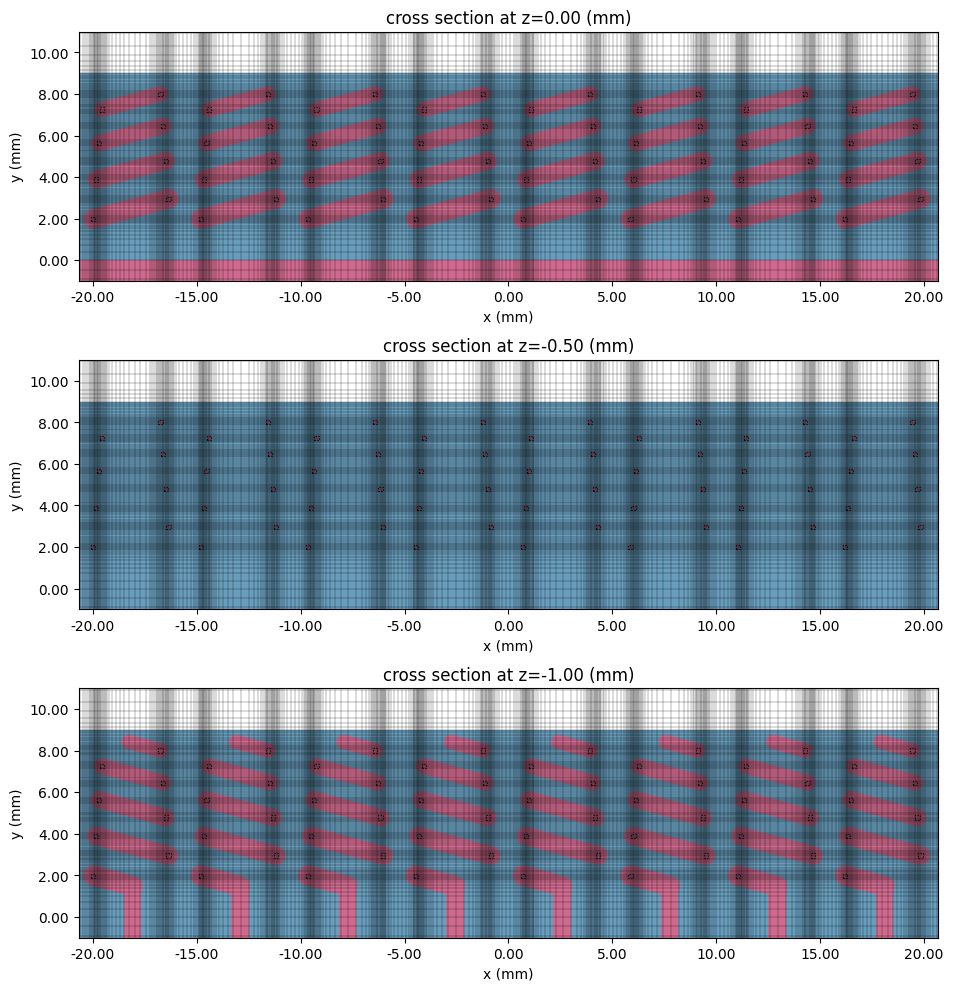

In [18]:
# Plot structures and grid on each layer (or interface between two layers)
fig, ax = plt.subplots(3, 1, figsize=(10, 10), tight_layout=True)
tcm.plot_sim(z=0, ax=ax[0])
tcm.simulation.plot_grid(z=0, ax=ax[0])
tcm.plot_sim(z=-H / 2, ax=ax[1], monitor_alpha=0)
tcm.simulation.plot_grid(z=-H / 2, ax=ax[1])
tcm.plot_sim(z=-H, ax=ax[2])
tcm.simulation.plot_grid(z=-H, ax=ax[2])
for axis in ax:
    axis.set_xlim(-N_ant / 2 * spacing, N_ant / 2 * spacing)
    axis.set_ylim(-1 * mm, 11 * mm)
plt.show()

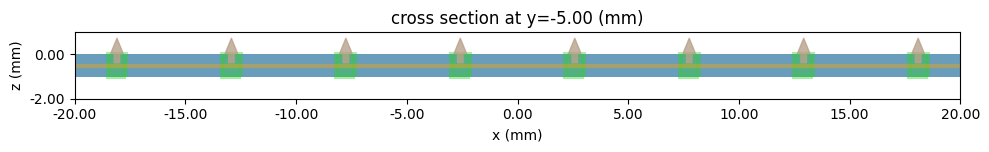

In [19]:
# Show lumped ports
fig, ax = plt.subplots(figsize=(10, 4), tight_layout=True)
tcm.plot_sim(y=-feed_offset, ax=ax)
ax.set_xlim(-20 * mm, 20 * mm)
ax.set_ylim(-2 * mm, 1 * mm)
plt.show()

In [20]:
# Show set up in 3D viewer
sim.plot_3d()

## Running the Simulation

The simulation is executed below. 

In [21]:
tcm_data = web.run(
    tcm, task_name="planar_helical_antenna_array", path="data/planar_helical_ant_array.hdf5"
)

08:55:40 EST Created task 'planar_helical_antenna_array' with resource_id       
             'sid-3e6fe4b6-5499-46c3-b369-ccfb230709d0' and task_type           
             'TERMINAL_CM'.

             View task using web UI at                                          
             ]8;id=74157;https://tidy3d.simulation.cloud/rf?taskId=pa-d5fcce25-deca-4af1-8238-55b59a0b6098\'https://tidy3d.simulation.cloud/rf?]8;;\]8;id=861156;https://tidy3d.simulation.cloud/rf?taskId=pa-d5fcce25-deca-4af1-8238-55b59a0b6098\taskId]8;;\]8;id=74157;https://tidy3d.simulation.cloud/rf?taskId=pa-d5fcce25-deca-4af1-8238-55b59a0b6098\=]8;;\]8;id=396651;https://tidy3d.simulation.cloud/rf?taskId=pa-d5fcce25-deca-4af1-8238-55b59a0b6098\pa]8;;\]8;id=74157;https://tidy3d.simulation.cloud/rf?taskId=pa-d5fcce25-deca-4af1-8238-55b59a0b6098\-d5fcce25-deca-4af1-82]8;;\
             ]8;id=74157;https://tidy3d.simulation.cloud/rf?taskId=pa-d5fcce25-deca-4af1-8238-55b59a0b6098\38-55b59a0b6098']8;;\.

             Task folder: ]8;id=688159;https://tidy3d.simulation.cloud/folders/f89aec3e-3357-4624-9c24-096a87582f12\'default']8;;\.

Output()

08:55:48 EST Maximum FlexCredit cost: 4.100. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' after run.

08:55:49 EST Subtasks status - planar_helical_antenna_array                     
             Group ID: 'pa-d5fcce25-deca-4af1-8238-55b59a0b6098'

Output()

             Batch status = preprocess

08:56:02 EST Batch status = running

08:57:42 EST Batch status = postprocess

08:58:14 EST Modeler has finished running successfully.

             Billed flex credit cost: 2.636.

Output()

08:58:25 EST Loading component modeler data from                                
             data/planar_helical_ant_array.hdf5

## Results

### Near-field Profile

The field monitor data corresponding to lumped port 4 is loaded below. 

In [22]:
sim_data = tcm_data.data["LP4"]

The field magnitude data at the operating frequency is plotted below. 

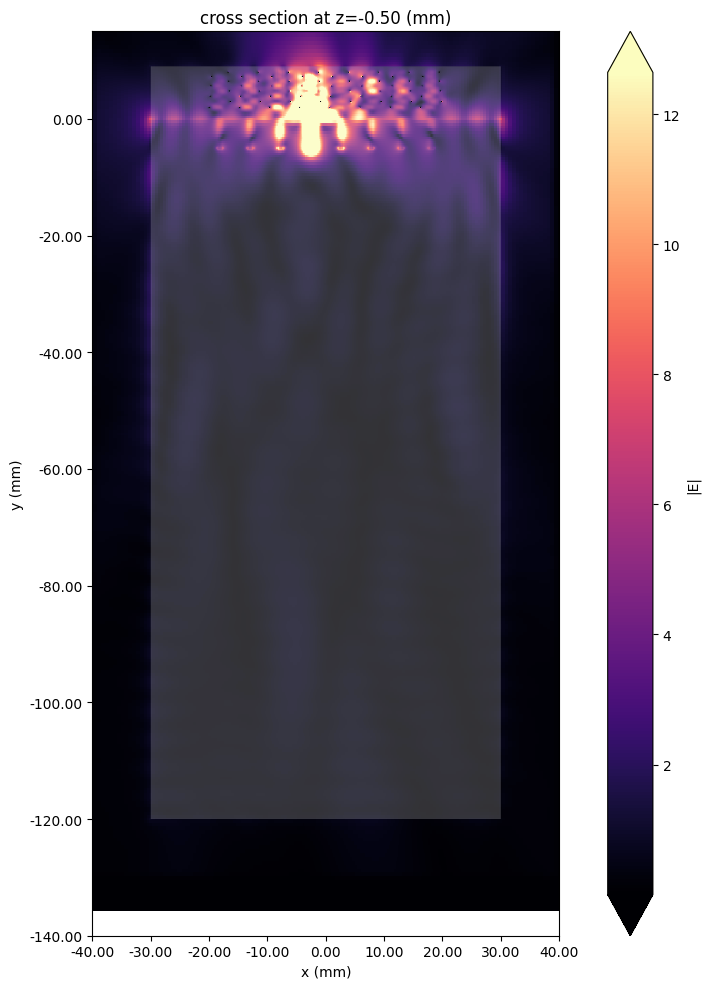

In [23]:
fig, ax = plt.subplots(figsize=(10, 10), tight_layout=True)
sim_data.plot_field(
    "field in-plane",
    field_name="E",
    val="abs",
    scale="lin",
    f=f_target,
    ax=ax,
)
ax.set_xlim(-40 * mm, 40 * mm)
ax.set_ylim(-140 * mm, 15 * mm)
plt.show()

### S-parameters

We define some convenience functions to extract the individual S-parameters from the simulation data. 

In [24]:
# Calculate full S-matrix
smat = tcm_data.smatrix()


# Convenience functions to get S_ij
# Note that port_in and port_out are zero-indexed (first port is number zero)
def sparam(i, j):
    return np.conjugate(smat.data.isel(port_in=j - 1, port_out=i - 1))


def sparam_abs(i, j):
    return np.abs(sparam(i, j))


def sparam_dB(i, j):
    return 20 * np.log10(sparam_abs(i, j))

The diagonal S-parameters are plotted below. The target operating frequency is indicated with the black dashed line. All 8 antennas resonate reasonably well at the operating frequency. 

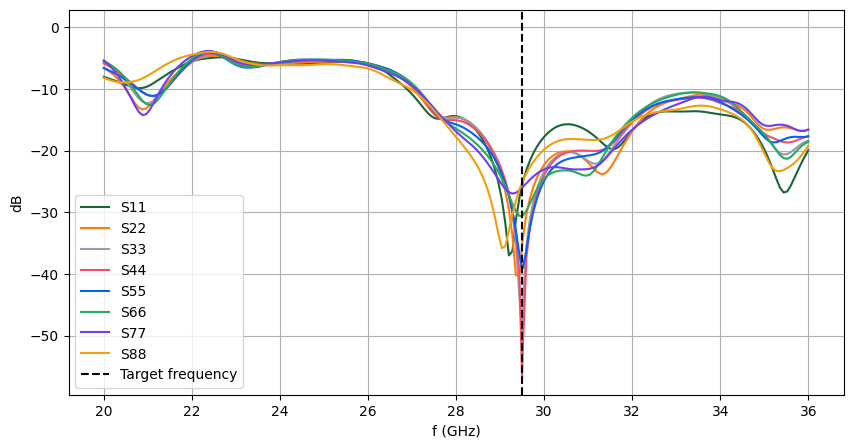

In [25]:
# Plot diagonal S-parameters
fig, ax = plt.subplots(figsize=(10, 5))
for ii in range(N_ant):
    ax.plot(freqs / 1e9, sparam_dB(ii + 1, ii + 1), label=f"S{ii + 1}{ii + 1}")
ax.axline(
    (f_target / 1e9, 0), (f_target / 1e9, -30), ls="--", color="black", label="Target frequency"
)
ax.grid()
ax.legend()
ax.set_xlabel("f (GHz)")
ax.set_ylabel("dB")
plt.show()

Below, we visualize the S-matrix (dB) at the target frequency. Good isolation is observed between adjacent elements (off-diagonal matrix values).

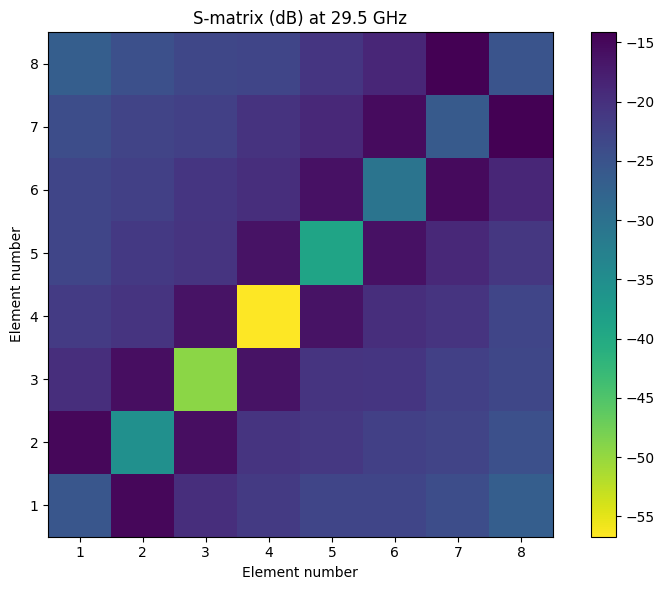

In [26]:
SdB_f_target = 20 * np.log10(np.abs(smat.data.sel(f=f_target, method="nearest")))

# 2D plot S-matrix (dB)
qq, pp = np.meshgrid(np.arange(1, 9), np.arange(1, 9))
fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)
pcm = ax.pcolormesh(qq, pp, SdB_f_target, shading="nearest", cmap="viridis_r")
cbar = fig.colorbar(pcm)
ax.set_xlabel("Element number")
ax.set_ylabel("Element number")
ax.set_title("S-matrix (dB) at 29.5 GHz")
ax.set_aspect(1)
plt.show()

### Generating Different Feed Patterns

We can specify arbitrary combinations of port feed patterns using the `port_amplitudes` parameter of `get_antenna_metrics_data()`. This allows us to visualize the radiation pattern for different scan angles, as well as generate the total scan pattern. 

The `port_amplitudes` parameter accepts a dictionary where each key corresponds to the port name, e.g. `LP1`, and the value is a complex number representing the port phase and amplitude. Below, we use a `for` loop to generate a list of feed patterns corresponding to different phase shifts between each antenna element (same amplitude). 

In [27]:
# List of fractional phase shifts
target_frac = np.linspace(-1, 1, 33)

# Generate list of feed patterns
feed_patterns = []
for frac in target_frac:
    phase_shift = np.pi * frac
    feed_dict = {}
    for ii in range(N_ant):
        port_name = f"LP{ii + 1}"
        feed_phase = np.exp(1j * phase_shift * ii)
        feed_dict[port_name] = feed_phase
    feed_patterns += [feed_dict]

Using the list of different feed patterns, we can then calculate a list of `AntennaMetricsData` data corresponding to each feed pattern. Note that the calculation can take some time for large datasets. 

In [28]:
# Generate a list of antenna metrics corresponding to each feed pattern
AM_list = [tcm_data.get_antenna_metrics_data(port_amplitudes=feed) for feed in feed_patterns]

### Gain and Total Scan Pattern

We visualize the azimuthal gain pattern in the x-y plane below. The main lobe of the array can be clearly observed to sweep from 45 degrees to 135 degrees as the phase difference between each element is changed. (For legibility reasons, only a subset of the scan patterns are shown and the plotting minimum range is set to -10 dB.)

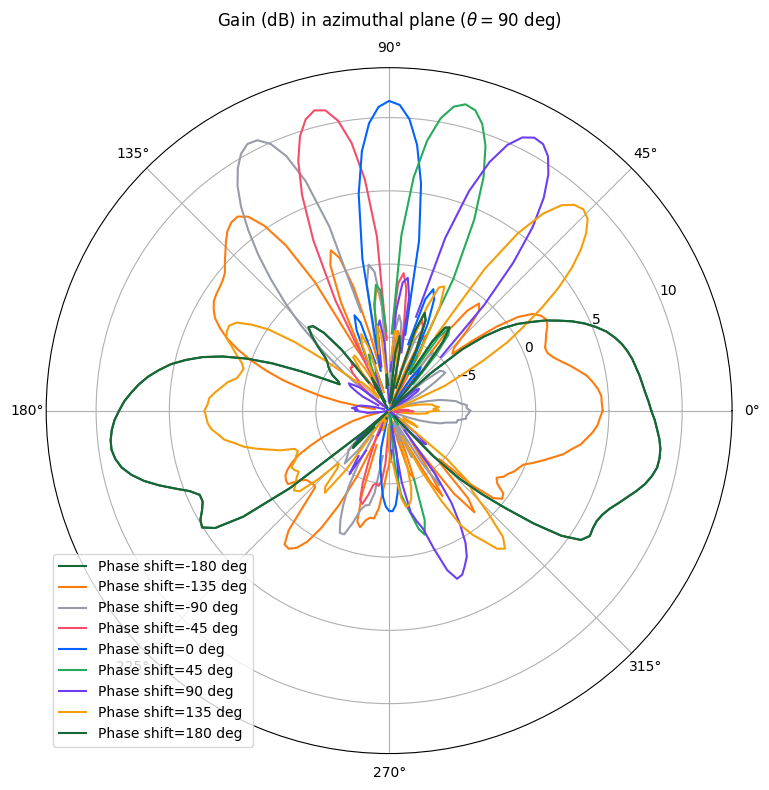

In [29]:
# Extract gain from antenna metrics
gain_list = [am.gain for am in AM_list]

# Gain comparison plot
fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True, subplot_kw={"projection": "polar"})

for ii, gain in enumerate(gain_list[::4]):
    gplot = gain.sel(theta=np.pi / 2, method="nearest").squeeze()
    ax.plot(phi, 10 * np.log10(gplot), label=f"Phase shift={target_frac[4 * ii] * 180:.0f} deg")

ax.set_title("Gain (dB) in azimuthal plane ($\\theta=90$ deg)", pad=30)
ax.set_rmin(-10)
ax.legend()
plt.show()

Using the `LobeMeasurer` utility, we can obtain metrics for the main and side lobes, such as direction, magnitude, and -3 dB beamwidth. Below, we measure the main lobe and the two adjacent side lobes for each feed pattern and record their properties in a `pandas.DataFrame` table. 

In [31]:
# Get main and side lobe characteristics for each feed pattern
df_list = []
label_list = []
for ii, gain in enumerate(gain_list):
    # Define string label for each feed pattern
    label_list += [f"{target_frac[ii] * 180:.0f}"]
    # Use rf.LobeMeasurer to get lobe metrics
    data = gain.sel(theta=np.pi / 2, method="nearest").squeeze()
    lm = rf.LobeMeasurer(angle=phi, radiation_pattern=data)
    # Pick out main lobe and two adjacent side lobes
    max_index = lm.lobe_measures["magnitude"].idxmax()
    lobe_data = lm.lobe_measures.iloc[max_index - 1 : max_index + 2].reset_index()[
        ["direction", "magnitude", "beamwidth"]
    ]
    # Append to lobe metrics to list
    df_list += [lobe_data]

In [32]:
# Concatenate individual tables into one big table
lobe_data_table = pd.concat(df_list, keys=label_list)

# Re-arrange columns and convert units
lobe_data_table = lobe_data_table.unstack()
lobe_data_table.index.name = "Phase shift (deg)"
lobe_data_table["direction"] = lobe_data_table["direction"] / np.pi * 180
lobe_data_table["beamwidth"] = lobe_data_table["beamwidth"] / np.pi * 180
lobe_data_table = lobe_data_table.rename(
    columns={
        "direction": "Direction (deg)",
        "magnitude": "Mag.",
        "beamwidth": "-3dB Beamwidth (deg)",
    },
    level=0,
)

# Regroup columns by main/side lobes
lobe_data_table = lobe_data_table.sort_index(axis=1, level=1, sort_remaining=False).reorder_levels(
    [1, 0], axis=1
)
# Relabel columns
lobe_data_table = lobe_data_table.rename(
    columns={0: "Side Lobe 1", 1: "Main Lobe", 2: "Side Lobe 2"}, level=0
)

# Display table
lobe_data_table

Side Lobe 1                                 \
                  Direction (deg)      Mag. -3dB Beamwidth (deg)   
Phase shift (deg)                                                  
-180                        134.0  0.620004            18.006084   
-169                        328.0  2.855913            63.118770   
-158                        308.0  0.222154           110.715653   
-135                        110.0  1.458950             7.744402   
-124                        108.0  1.329883             8.009338   
-112                        104.0  1.209504             7.221359   
-101                        100.0  1.049384             7.359342   
-90                          98.0  1.014581             7.044445   
-79                          94.0  0.950609             6.974312   
-68                          92.0  0.840098             7.461656   
-56                          88.0  0.846758             7.260991   
-45                          84.0  0.878121             7.096974   
-34                          80.0  0.829221             7.775574   
-22                          78.0  0.813133             7.937543   
-11                          74.0  0.838832             7.606582   
0                            70.0  0.762165             8.010417   
11                           66.0  0.706618             7.966041   
22                           62.0  0.652181             8.277659   
34                           58.0  0.596784             8.233915   
45                           54.0  0.502738             8.453348   
56                           50.0  0.391363             8.714127   
68                           46.0  0.268768             9.239750   
79                           42.0  0.188618            10.582732   
90                           36.0  0.178494            12.716537   
101                          32.0  0.241713            49.347015   
112                          28.0  0.256847            53.102942   
124                          12.0  0.218673            80.477483   
135                          18.0  0.114624           105.988198   
158                         150.0  1.029767            70.249544   
169                         148.0  0.484174            91.293511   
180                         134.0  0.620004            18.006084   

                        Main Lobe                                  \
                  Direction (deg)       Mag. -3dB Beamwidth (deg)   
Phase shift (deg)                                                   
-180                        188.0   8.198536            28.340757   
-169                        352.0   9.158275            39.295362   
-158                        358.0   8.936850            35.201744   
-135                        128.0   4.791148            27.740443   
-124                        128.0   7.532424            19.251698   
-112                        124.0   9.321255            17.386744   
-101                        120.0  10.436325            15.793280   
-90                         118.0  11.515368            14.661542   
-79                         114.0  12.338675            13.602179   
-68                         110.0  12.768028            13.110374   
-56                         108.0  12.612925            12.984227   
-45                         104.0  12.931682            12.373767   
-34                         100.0  12.724138            12.237446   
-22                          96.0  12.247619            12.477811   
-11                          94.0  12.430376            12.159187   
0                            90.0  12.992111            11.815260   
11                           86.0  12.989350            12.210519   
22                           82.0  12.973266            12.712960   
34                           80.0  13.610419            12.742327   
45                           76.0  14.274513            12.852585   
56                           72.0  14.396497            13.228996   
68                           68.0  14.100946         

We can also combine all the gain patterns using `np.max()` to generate the total scan pattern. The total scan pattern shows the maximum achievable gain for the whole array at a given angle coordinate. 

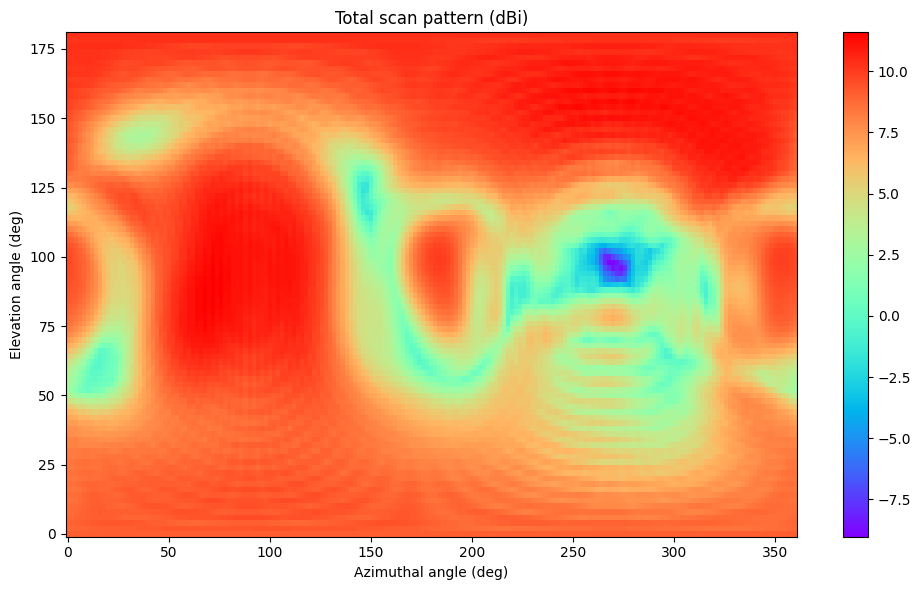

In [33]:
# Calculate total scan pattern
full_gain_list = 10 * np.log10(np.abs(np.array(gain_list))).squeeze()
scan_max = np.max(full_gain_list, axis=0)  # max gain at given angle

# 2D plot of total scan pattern
qq, pp = np.meshgrid(phi / np.pi * 180, theta / np.pi * 180)
fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)
pcm = ax.pcolormesh(qq, pp, scan_max, shading="nearest", cmap="rainbow")
cbat = fig.colorbar(pcm)
ax.set_xlabel("Azimuthal angle (deg)")
ax.set_ylabel("Elevation angle (deg)")
ax.set_title("Total scan pattern (dBi)")
plt.show()

### Axial Ratio

We calculate the axial ratio (AR) of the main lobe in the azimuthal (x-y) plane for each scan angle. We will use a subset of the scan pattern that covers the 45 to 135 degree arc. First, we locate the main lobe angle. 

In [34]:
# Calculate main lobe azimuthal angle for each scan pattern
main_lobe_angles = []
for gain in gain_list[5:29]:
    lobe_angle = phi[np.argmax(gain.sel(theta=np.pi / 2, method="nearest").squeeze().data)]
    main_lobe_angles += [lobe_angle]
main_lobe_angles = np.array(main_lobe_angles)

Then, we extract the axial ratio at each scan angle.

In [35]:
# Extract AR for phi = main lobe angle, theta = 90 degrees
AR_list = [
    am.axial_ratio.sel(theta=np.pi / 2, phi=main_lobe_angles[ii], method="nearest").squeeze()
    for ii, am in enumerate(AM_list[5:29])
]

The AR is plotted against the scan angle below.

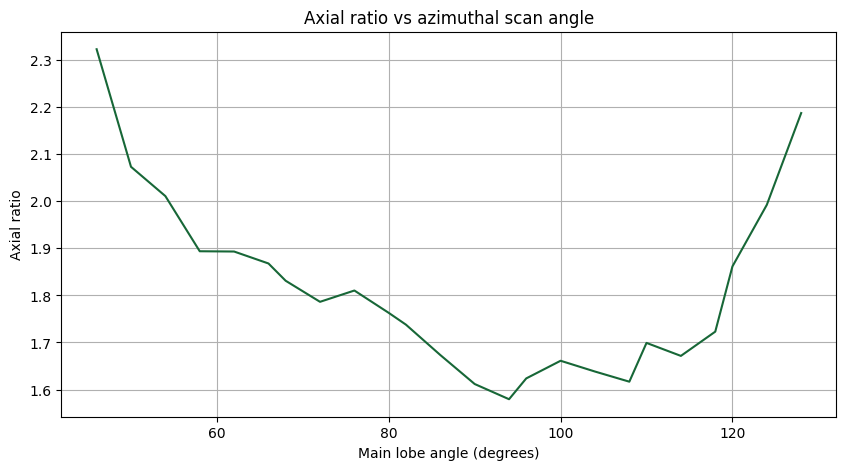

In [36]:
# Plot AR vs main lobe angle
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(main_lobe_angles / np.pi * 180, AR_list)
ax.grid()
ax.set_title("Axial ratio vs azimuthal scan angle")
ax.set_xlabel("Main lobe angle (degrees)")
ax.set_ylabel("Axial ratio")
plt.show()

## Reference

[1] Syrytsin, Igor, Shuai Zhang, and Gert Fr. "Circularly polarized planar helix phased antenna array for 5G mobile terminals." In 2017 International Conference on Electromagnetics in Advanced Applications (ICEAA), pp. 1105-1108. IEEE, 2017.